In [2]:
import torch, platform, sys
print("Python:", sys.executable)
print("PyTorch:", torch.__version__)
print("CUDA disponível?", torch.cuda.is_available())
mps_ok = getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
print("MPS (Apple) disponível?", bool(mps_ok))

Python: /opt/conda/envs/anaconda-ai-2024.04-py310/bin/python
PyTorch: 2.2.0
CUDA disponível? False
MPS (Apple) disponível? False


In [4]:
import torch
import matplotlib.pyplot as plt
from torch.autograd import grad

In [5]:
N1 = lambda xi, eta: 0.25 * (1 - xi) * (1 - eta)
N2 = lambda xi, eta: 0.25 * (1 + xi) * (1 - eta)
N3 = lambda xi, eta: 0.25 * (1 + xi) * (1 + eta)
N4 = lambda xi, eta: 0.25 * (1 - xi) * (1 + eta)

In [6]:
U = [0.0, 1.0, 2.0, 1.0]
V = [0.0, 0.0, 0.5, 0.8]
u = (
    lambda xi, eta:
    N1(xi, eta) * U[0]
    + N2(xi, eta) * U[1]
    + N3(xi, eta) * U[2]
    + N4(xi, eta) * U[3]
)
v = (
    lambda xi, eta: N1(xi, eta) * V[0]
                    + N2(xi, eta) * V[1]
                    + N3(xi, eta) * V[2]
                    + N4(xi, eta) * V[3]
)

In [7]:
nx = 5
ny = 5

x = torch.linspace(-1, 1, nx, requires_grad=True)
y = torch.linspace(-1, 1, ny, requires_grad=True)
x, y = torch.meshgrid(x, y, indexing="ij")

In [25]:
d = torch.cat((u(x, y).unsqueeze(0), v(x, y).unsqueeze(0)), 0)
# the following is achieved by the concatenation above
# d[0, :, :] == u(x,y)
# d[1, :, :] == v(x,y)

In [42]:
dd_dx = torch.zeros((2, 2, nx, ny))
dd_dx[0, 0] = grad(d[0], x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]
dd_dx[0, 1] = grad(d[0], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
dd_dx[1, 0] = grad(d[1], x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]
dd_dx[1, 1] = grad(d[1], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]

In [43]:
eps = 0.5 * (dd_dx + dd_dx.permute((1, 0, 2, 3)))

In [44]:
E = 210000.0
nu = 0.3

C = torch.zeros((2, 2, 2, 2))  # 4th order material tensor
C[0, 0, 0, 0] = 1.0
C[0, 0, 1, 1] = nu
C[1, 1, 0, 0] = nu
C[1, 1, 1, 1] = 1.0
C[0, 1, 0, 1] = (1.0 - nu) / 2.0
C = E / (1.0 - nu ** 2) * C

In [45]:
sig = torch.tensordot(C, eps)

In [1]:
import torch
from torch.autograd import grad

# ====== Grade (exemplo) ======
nx, ny = 64, 64
x1 = torch.linspace(-1.0, 1.0, nx)
y1 = torch.linspace(-1.0, 1.0, ny)
X0, Y0 = torch.meshgrid(x1, y1, indexing='ij')

# Torna X,Y LEAF TENSORS com grad
X = X0.clone().detach().requires_grad_(True)
Y = Y0.clone().detach().requires_grad_(True)

# ====== Exemplo de σ(x,y) (substitua pelo seu) ======
# σ11 = X**2 + 0.3*Y
# σ12 = σ21 = X*Y
# σ22 = Y**2 - 0.1*X
sig = torch.stack([
    torch.stack([X**2 + 0.3*Y, X*Y], dim=0),           # [σ11, σ12]
    torch.stack([X*Y,           Y**2 - 0.1*X], dim=0)  # [σ21, σ22]
], dim=0)  # shape: (2, 2, nx, ny)

# ====== Derivadas parciais (usamos .sum() para evitar grad_outputs) ======
# Atenção: mantenha retain_graph=True nas primeiras chamadas para não liberar o grafo.
dsig11_dx = grad(sig[0, 0].sum(), X, create_graph=True, retain_graph=True)[0]
dsig12_dy = grad(sig[0, 1].sum(), Y, create_graph=True, retain_graph=True)[0]
dsig21_dx = grad(sig[1, 0].sum(), X, create_graph=True, retain_graph=True)[0]
dsig22_dy = grad(sig[1, 1].sum(), Y, create_graph=True               )[0]

# ====== Divergência negativa (força de desequilíbrio) ======
f = torch.empty((2, nx, ny), dtype=sig.dtype, device=sig.device)
f[0] = -dsig11_dx - dsig12_dy
f[1] = -dsig21_dx - dsig22_dy

# Conferência rápida
print("sig.shape:", sig.shape)   # (2,2,nx,ny)
print("f.shape  :", f.shape)     # (2,nx,ny)
print("f centro :", f[:, nx//2, ny//2])


sig.shape: torch.Size([2, 2, 64, 64])
f.shape  : torch.Size([2, 64, 64])
f centro : tensor([-0.0476, -0.0476], grad_fn=<SelectBackward0>)


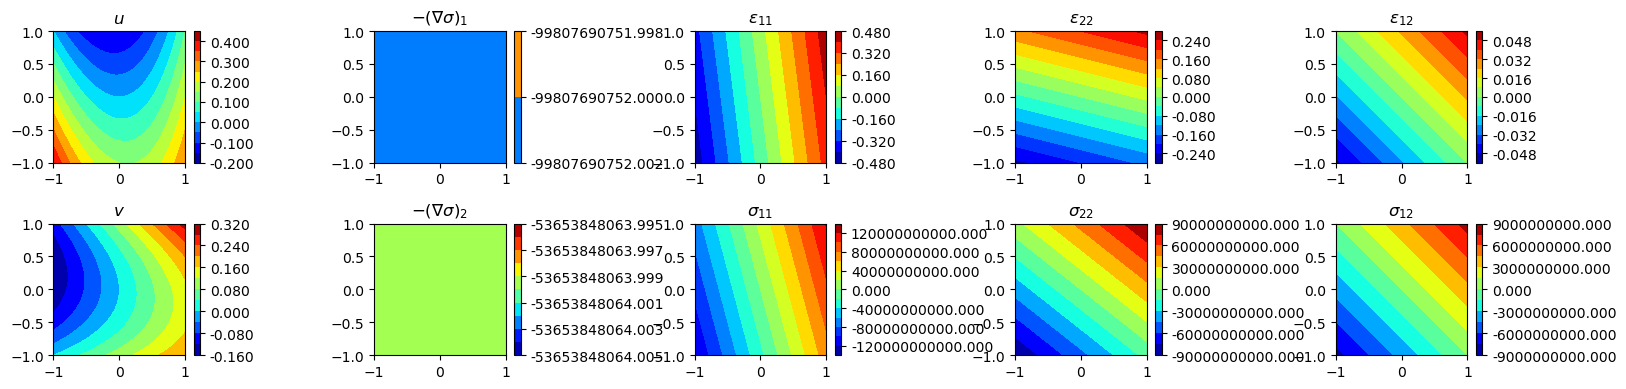

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

# =========================================================
# 1) Malha 2D com grad (leaf tensors)
# =========================================================
nx, ny = 81, 81
x = torch.linspace(-1.0, 1.0, nx)
y = torch.linspace(-1.0, 1.0, ny)
X0, Y0 = torch.meshgrid(x, y, indexing='ij')
X = X0.clone().detach().requires_grad_(True)
Y = Y0.clone().detach().requires_grad_(True)

# =========================================================
# 2) Cálculo de d (u,v), ε, σ (tensão plana isotrópica), f = –div σ
#    -> Apague esta seção se você já tem d, eps, sig, f
# =========================================================
# Campo de deslocamentos de exemplo (suave, com não linearidade)
a1, a2, a3 = 0.20, -0.15, 0.10
u = a1*X**2 + a2*Y + 0.05*X*Y
v = -a2*X + a3*Y**2 + 0.05*X*Y
d = torch.stack([u, v], dim=0)                # (2, nx, ny)

# Derivadas de u,v
dux_dx = grad(u.sum(), X, create_graph=True, retain_graph=True)[0]
dux_dy = grad(u.sum(), Y, create_graph=True, retain_graph=True)[0]
dvy_dx = grad(v.sum(), X, create_graph=True, retain_graph=True)[0]
dvy_dy = grad(v.sum(), Y, create_graph=True, retain_graph=True)[0]

# Pequenas deformações
eps11 = dux_dx
eps22 = dvy_dy
eps12 = 0.5*(dux_dy + dvy_dx)

# Empilha ε em formato (2,2,nx,ny)
eps = torch.stack([
    torch.stack([eps11, eps12], dim=0),
    torch.stack([eps12, eps22], dim=0)
], dim=0)

# Material isotrópico (tensão plana)
E, nu = 210e9, 0.3
Cps = (E/(1-nu**2)) * torch.tensor([
    [1.0, nu, 0.0],
    [nu, 1.0, 0.0],
    [0.0, 0.0, (1-nu)/2]
], dtype=X.dtype)

# Voigt: [eps_xx, eps_yy, gamma_xy] com gamma_xy = 2*eps_xy
eps_voigt = torch.stack([eps11, eps22, 2*eps12], dim=0)  # (3, nx, ny)

# σ em Voigt: [σxx, σyy, τxy]
sig_voigt = torch.stack([
    Cps[0,0]*eps_voigt[0] + Cps[0,1]*eps_voigt[1] + Cps[0,2]*eps_voigt[2],
    Cps[1,0]*eps_voigt[0] + Cps[1,1]*eps_voigt[1] + Cps[1,2]*eps_voigt[2],
    Cps[2,0]*eps_voigt[0] + Cps[2,1]*eps_voigt[1] + Cps[2,2]*eps_voigt[2],
], dim=0)  # (3, nx, ny)

sig11 = sig_voigt[0]
sig22 = sig_voigt[1]
sig12 = sig_voigt[2]  # τxy = σ12 = σ21 no contínuo
sig = torch.stack([
    torch.stack([sig11, sig12], dim=0),
    torch.stack([sig12, sig22], dim=0)
], dim=0)  # (2,2,nx,ny)

# Divergência de σ (f = –div σ)
dsig11_dx = grad(sig11.sum(), X, create_graph=False, retain_graph=True)[0]
dsig12_dy = grad(sig12.sum(), Y, create_graph=False, retain_graph=True)[0]
dsig21_dx = grad(sig12.sum(), X, create_graph=False, retain_graph=True)[0]  # σ21 = σ12
dsig22_dy = grad(sig22.sum(), Y, create_graph=False, retain_graph=False)[0]
f = torch.empty((2, nx, ny), dtype=X.dtype)
f[0] = -(dsig11_dx + dsig12_dy)
f[1] = -(dsig21_dx + dsig22_dy)

# =========================================================
# 3) Plot 2×5
# =========================================================
def to_np(t): return t.detach().cpu().numpy()

titles = [
    r"$u$",
    r"$-(\nabla \sigma)_{1}$",
    r"$\epsilon_{11}$",
    r"$\epsilon_{22}$",
    r"$\epsilon_{12}$",
    r"$v$",
    r"$-(\nabla \sigma)_{2}$",
    r"$\sigma_{11}$",
    r"$\sigma_{22}$",
    r"$\sigma_{12}$",
]

fields = [
    d[0],          # u
    f[0],          # -(∇σ)_1
    eps[0, 0],     # ε11
    eps[1, 1],     # ε22
    eps[0, 1],     # ε12
    d[1],          # v
    f[1],          # -(∇σ)_2
    sig[0, 0],     # σ11
    sig[1, 1],     # σ22
    sig[0, 1],     # σ12
]

# Sanidade: shapes
nx_, ny_ = X.shape
for k, Z in enumerate(fields):
    assert Z.shape == X.shape, f"fields[{k}] tem shape {tuple(Z.shape)}, esperado {(nx_, ny_)}."

fig, ax = plt.subplots(2, 5, figsize=(16, 4))
for k, (Z, ttl) in enumerate(zip(fields, titles)):
    i, j = divmod(k, 5)
    cp = ax[i, j].contourf(to_np(X), to_np(Y), to_np(Z), levels=12, cmap='jet')
    fig.colorbar(cp, ax=ax[i, j], format="%.3f")
    ax[i, j].set_aspect("equal", adjustable='box')
    ax[i, j].set_title(ttl)

fig.tight_layout()
plt.show()
